# Compare model output with ASTE and observations

Load selected mooring time series and plot CANARI LE, ASTE and obs (see choose_ASTE_profiles and subset_CANARI_LE)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import utils

In [2]:
%matplotlib inline

Load ASTE data

In [3]:
import glob
mooring_files=glob.glob('../data/*tseries.nc')
mooring_vars={}
for file in mooring_files:
    mooring=xr.open_dataset(file)
    if 'iPROF' in mooring.dims:
        mooring=mooring.swap_dims({'iPROF':'time'})
    mooring=mooring.sortby('time').squeeze()
    if 'point' in mooring.dims:
        for ip,point in enumerate(mooring.point):
            mooring_vars[f'{mooring["loc"].values}_{ip}']=mooring[['prof_T','prof_Testim','prof_S','prof_Sestim']].sel(point=point)
    else:
        mooring_vars[str(mooring['loc'].values)]=mooring[['prof_T','prof_Testim','prof_S','prof_Sestim']]

Load CANARI LE data

In [29]:
def preproc(ds):
    ensname=ds.encoding['source'].split('_')[-1].split('.')[0]
    ds['ens']=ensname
    return ds
Tdata_allm=xr.open_mfdataset(f'../data/mooring_tseries_ens*nc',concat_dim='ens',combine='nested',preprocess=preproc)
Tdata_allm=Tdata_allm.assign_coords({'loc':['Beaufort Mooring', 'Bering Mooring', 'Davis Mooring', 'Fram Mooring',
       'OSNAP Mooring_0', 'OSNAP Mooring_1']})

Load CMIP6 data

In [5]:
#models=['HadGEM3-GC31-MM','GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR', 'MRI-ESM2-0']
models=['HadGEM3-GC31-MM','GFDL-ESM4','IPSL-CM6A-LR',]
Cdata_allm=[]
for model in models:
    Cdata_allm_T=xr.open_mfdataset(f'../data/mooring_tseries_{model}*thetao.nc',concat_dim=['run'],combine='nested')
    Cdata_allm_S=xr.open_mfdataset(f'../data/mooring_tseries_{model}*so.nc',concat_dim=['run'],combine='nested')
    Cdata_allm.append(xr.merge([Cdata_allm_T['thetao'],Cdata_allm_S['so']]))
Cdata_allm=xr.concat(Cdata_allm,'model'
                #     ,compat='override',coords='minimal'
                    )
Cdata_allm=Cdata_allm.assign_coords({'loc':['Beaufort Mooring', 'Bering Mooring', 'Davis Mooring', 'Fram Mooring',
       'OSNAP Mooring_0', 'OSNAP Mooring_1']})
Cdata_allm

<xarray.Dataset>
Dimensions:     (time: 304, run: 13, model: 3, loc: 6)
Coordinates:
  * time        (time) datetime64[ns] 2000-01-16 ... 2014-12-16T12:00:00
  * run         (run) <U8 'r1i1p1f1' 'r1i1p1f3' ... 'r8i1p1f1' 'r9i1p1f1'
    y           (model, loc) float64 dask.array<chunksize=(1, 6), meta=np.ndarray>
    x           (model, loc) float64 dask.array<chunksize=(1, 6), meta=np.ndarray>
    lat         (model, loc) float32 dask.array<chunksize=(1, 6), meta=np.ndarray>
    lon         (model, loc) float32 dask.array<chunksize=(1, 6), meta=np.ndarray>
    lev         (loc) float64 573.0 45.0 265.7 87.59 983.3 597.7
    prof_point  (loc) float64 1.134e+06 8.344e+05 ... 7.538e+05 7.992e+05
    depth       (loc) float64 573.0 45.0 265.7 87.59 983.3 597.7
    point       (loc) float64 1.134e+06 8.344e+05 ... 7.538e+05 7.992e+05
  * model       (model) <U15 'HadGEM3-GC31-MM' 'GFDL-ESM4' 'IPSL-CM6A-LR'
  * loc         (loc) <U16 'Beaufort Mooring' ... 'OSNAP Mooring_1'
Data variables:
    thetao      (model, run, loc, time) float32 dask.array<chunksize=(1, 2, 6, 304), meta=np.ndarray>
    so          (model, run, loc, time) float32 dask.array<chunksize=(1, 2, 6, 304), meta=np.ndarray>
Attributes:
    long_name:      Sea Water Potential Temperature
    original_name:  mo: (variable_name: thetao)
    standard_name:  sea_water_potential_temperature
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        mo: This variable is reported using a z* coordinate syste...
    units:          °C

Combine CANARI-LE with HadGEM3-GC31-MM data

In [60]:
#import utils as ut
#import importlib as imp
#imp.reload(ut)
Tdata_new=ut.rename_cmip6(Tdata_allm)
Tdata_new=Tdata_new.rename({'vosaline':'so','votemper':'thetao','ens':'run'})
Tdata_new=Tdata_new.expand_dims(dim={'model':3})
Tdata_new=Tdata_new.assign_coords({'model':('model',models)})
omodels=list(set(models)-set(['HadGEM3-GC31-MM',]))
Tdata_new.loc[dict(model=omodels)]=np.nan

/gws/nopw/j04/canari/users/emmomp/proj-Arctic-Ocean/notebooks/utils.py:65: UserWarning: rename 'time_counter' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  
/gws/nopw/j04/canari/users/emmomp/proj-Arctic-Ocean/notebooks/utils.py:83: UserWarning: CANARI-LE.none.none..none.none.gn.none.none:While renaming to target `lev`, more than one candidate was found ['deptht', 'depth']. Renaming deptht to lev. Please double check results.
  )


In [68]:
comb_data=xr.concat([Cdata_allm,Tdata_new],'run')

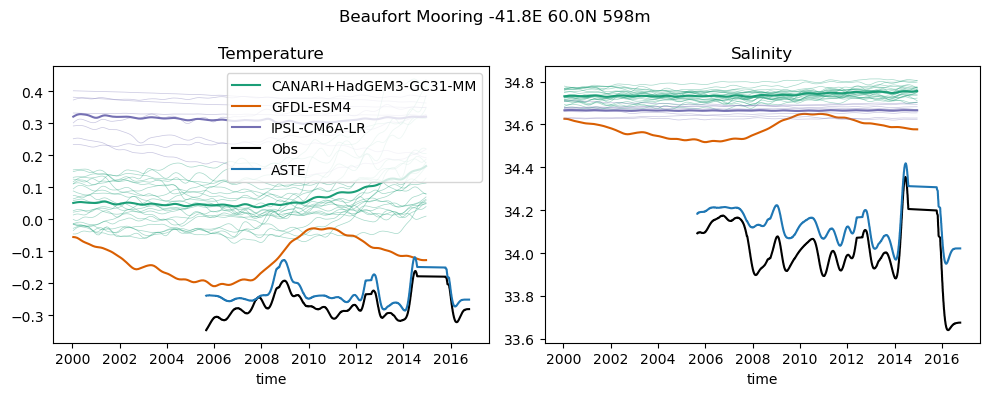

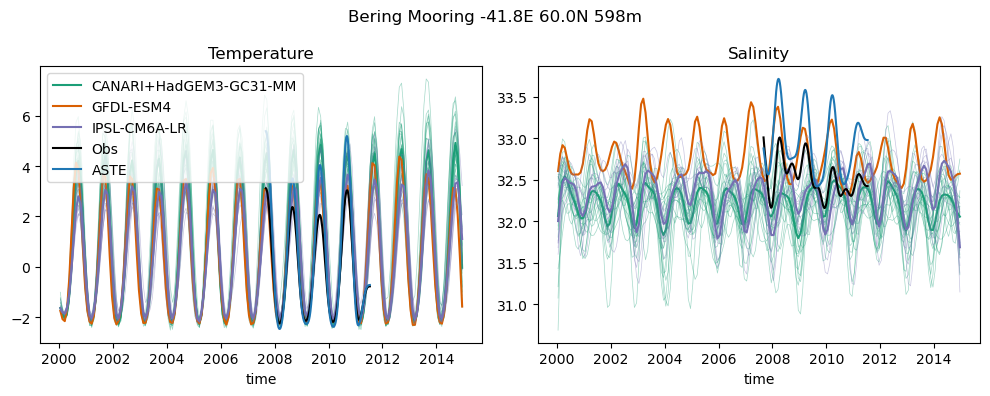

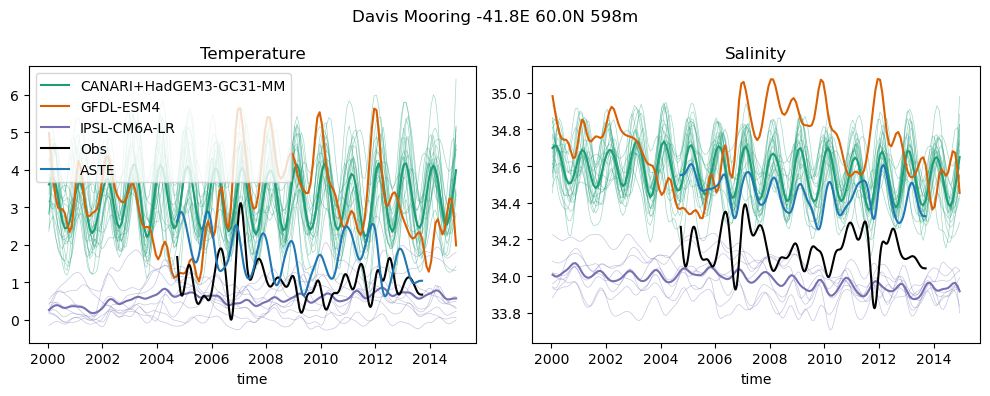

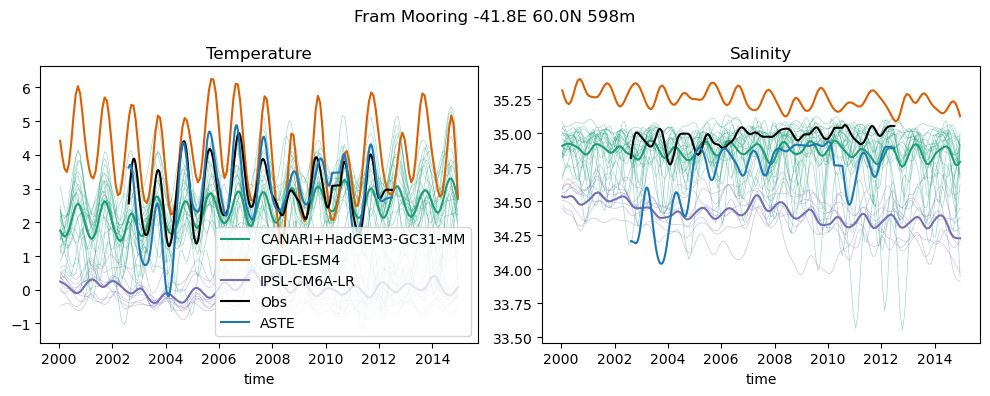

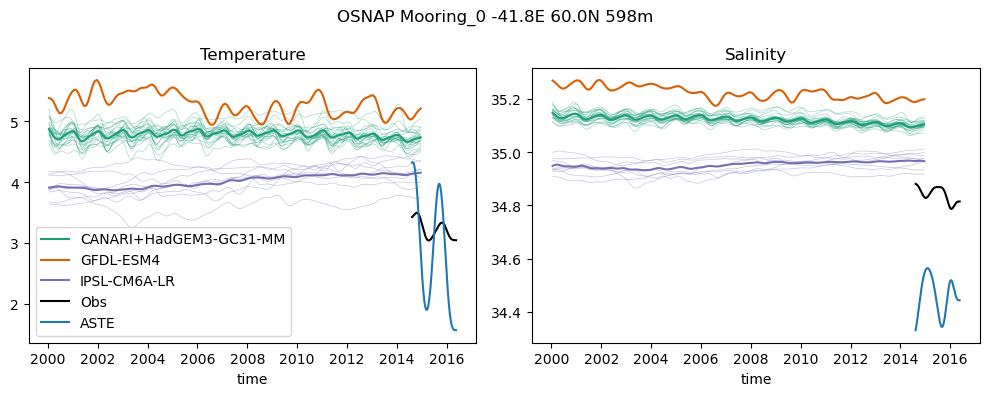

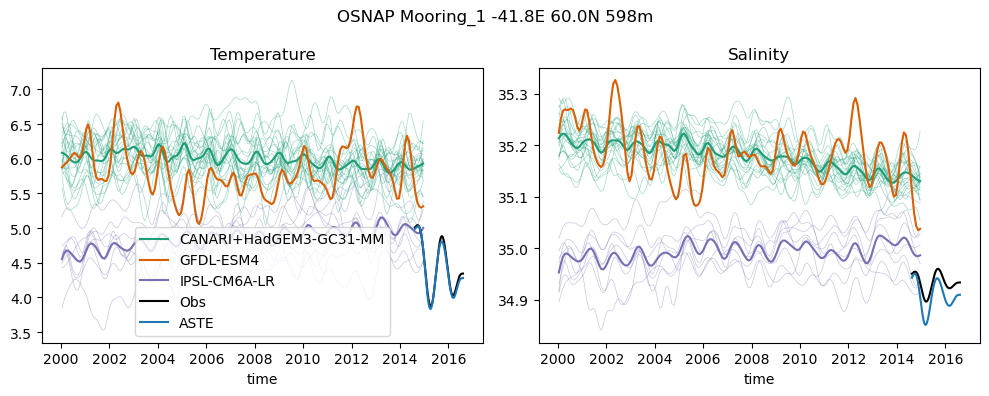

In [69]:
cmap=plt.get_cmap('Dark2')
ASTEvar={'thetao':'prof_Testim','so':'prof_Sestim'}
OBSvar={'thetao':'prof_T','so':'prof_S'}
var_label={'thetao':'Temperature','so':'Salinity'}

for loc in mooring_vars:
    plt.figure(figsize=[10,4])
    for iv,var in enumerate(['thetao','so']):
        plt.subplot(1,2,iv+1)
   # Tdata_plot=Tdata_allm.sel(loc=loc)
   # Cdata_plot=Cdata_allm['thetao'].sel(loc=loc)
        Cdata_plot=comb_data[var].sel(loc=loc)
  #  utils.butter_ufunc(Tdata_plot.votemper.dropna('time_counter').load(),6,'time_counter').plot(x='time_counter',hue='ens',color=cmap(0),linewidth=0.5,add_legend=False,alpha=0.4)
 #   pp1=utils.butter_ufunc(Tdata_plot.votemper.dropna('time_counter').mean('ens').load(),6,'time_counter').plot(x='time_counter',color=cmap(0),add_legend=False)
  #  utils.butter_ufunc(Cdata_plot.thetao.dropna('time').load(),6,'time').plot(x='time',hue='run',color='r',linewidth=0.5,add_legend=False,alpha=0.4)
        pp2=[]
        for im,model in enumerate(models):
            if Cdata_plot.sel(model=model).dropna('run',how='all').run.size>1:
                utils.butter_ufunc(Cdata_plot.sel(model=model).dropna('time',how='all').load(),6,'time').plot(x='time',hue='run',color=cmap(im),add_legend=False,linewidth=0.5,alpha=0.4)
            pp2.append(utils.butter_ufunc(Cdata_plot.sel(model=model).mean('run').dropna('time').load(),6,'time').plot(x='time',color=cmap(im),add_legend=False)[0])
        pp3=utils.butter_ufunc(mooring_vars[loc][OBSvar[var]].dropna('time'),365.25/2,'time').plot(x='time',color='k')
        pp4=utils.butter_ufunc(mooring_vars[loc][ASTEvar[var]].dropna('time'),365.25/2,'time').plot(x='time')
        if iv==0:
            plt.legend(pp2+[pp3[0],pp4[0]],['CANARI+HadGEM3-GC31-MM',]+models[1:]+['Obs','ASTE'])
        plt.title(var_label[var])
        plt.ylabel('')
    plt.suptitle(f'{loc} {Tdata_plot.nav_lon.data:2.1f}E {Tdata_plot.nav_lat.data:2.1f}N {Tdata_plot.deptht.data:3.0f}m')
    plt.tight_layout()
    plt.savefig(f'../plots/{loc}_mooring_tseries.png',bbox_inches='tight')